In [1]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt
import glob
import skimage
import scipy
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from skimage import morphology

# BEE DETECT

In [37]:
# Load resources
train_imgs = np.array([np.array(imageio.imread(filename)) for filename in sorted(glob.glob('../TRAIN/*.jpg'))])
train_labels = np.array([np.array(np.genfromtxt(filename, delimiter=',')) for filename in sorted(glob.glob('../TRAIN/*.csv'))])

test_imgs = [np.array(imageio.imread(filename)) for filename in sorted(glob.glob('../TEST/*.jpg'))]
test_labels = np.array([np.array(np.genfromtxt(filename, delimiter=',')) for filename in sorted(glob.glob('../TEST/*.csv'))])

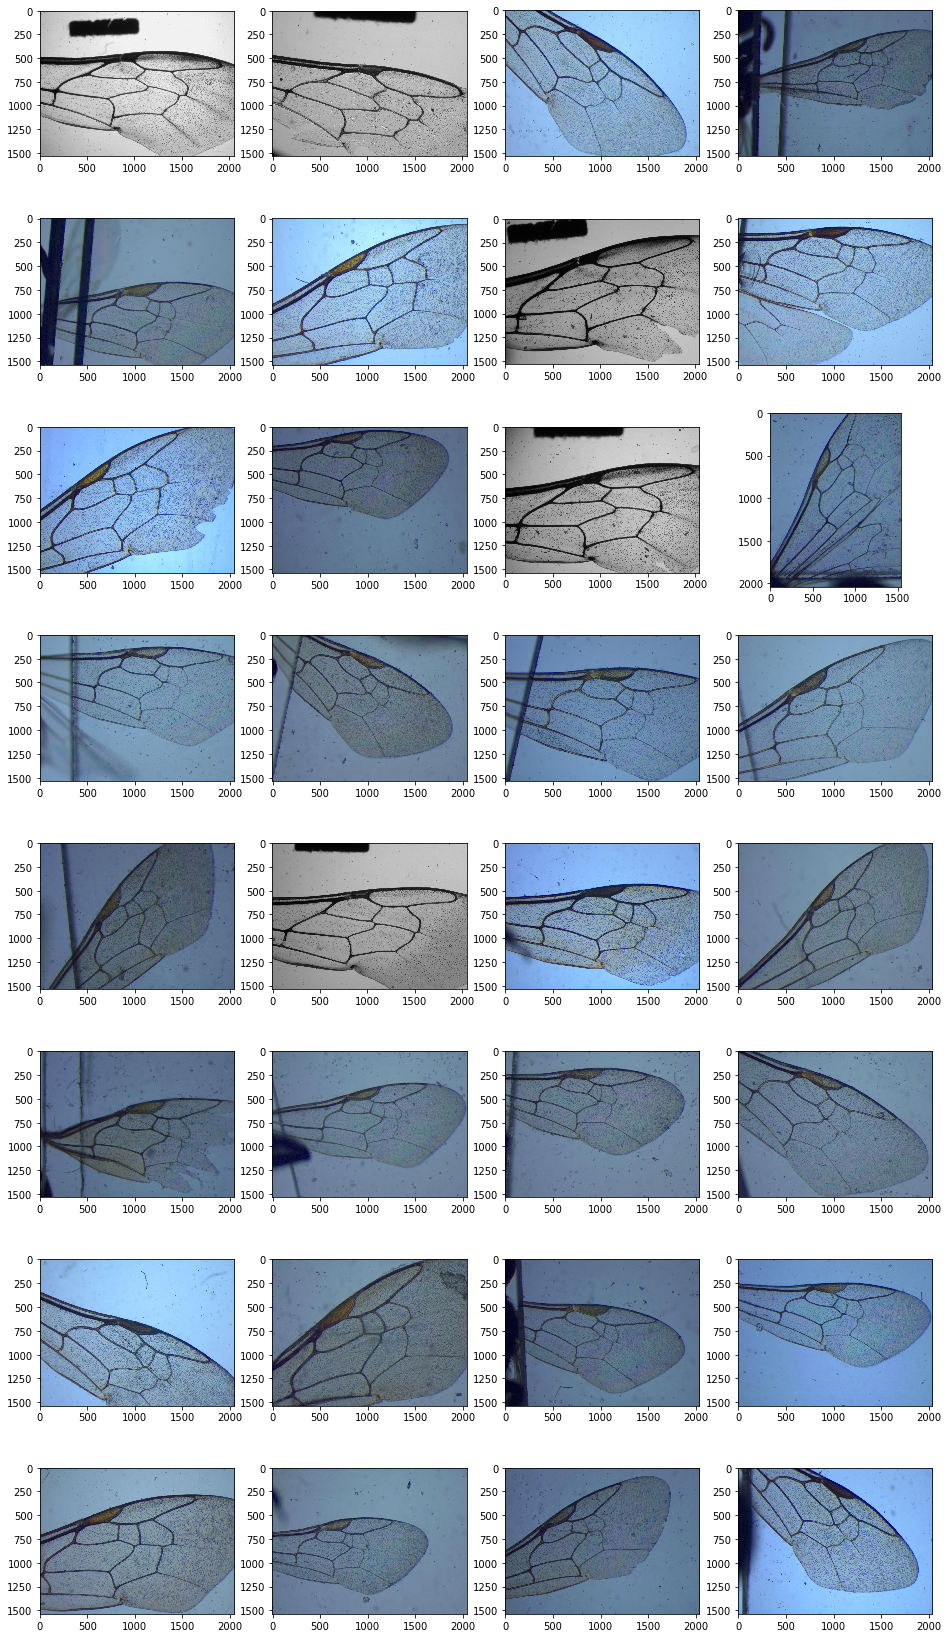

In [3]:
# Print all images from TRAIN
fig=plt.figure(figsize=(16, 30))
for i, img in enumerate(train_imgs):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(img)
plt.show()

In [5]:
# Draw points from CSV on the image
def draw_points(img, points):
    img_copy = img.copy()
    for point in points:
        cv2.circle(img_copy,(int(point[1]), int(point[0])), 20, (255,255,0), -1)
    return img_copy

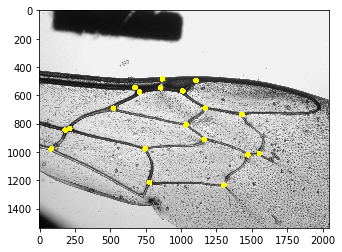

In [40]:
# Draw one image and CSV from TEST
test_img = test_imgs[0]
test_points = test_labels[0]
plt.imshow(draw_points(test_img, test_points))

# Results

In [7]:
def process(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_val = threshold_sauvola(gray, window_size=159)
    bin_img = (gray > threshold_val).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    blur = cv2.bilateralFilter(bin_img, 14, 75, 75)
    inv = np.invert(blur)
    img_dilate = cv2.dilate(inv, kernel, iterations=10)
    img_erode = cv2.erode(img_dilate, kernel, iterations=7)
    inv_img = np.invert(img_erode)
    all_labels = skimage.measure.label(1 - skimage.morphology.remove_small_objects((1 - inv_img).astype(bool),min_size=5000))
    kernel = np.ones((5,5), np.uint8)
    img_dilate = cv2.dilate(all_labels.astype(np.uint8), kernel, iterations=6) 
    return img_dilate

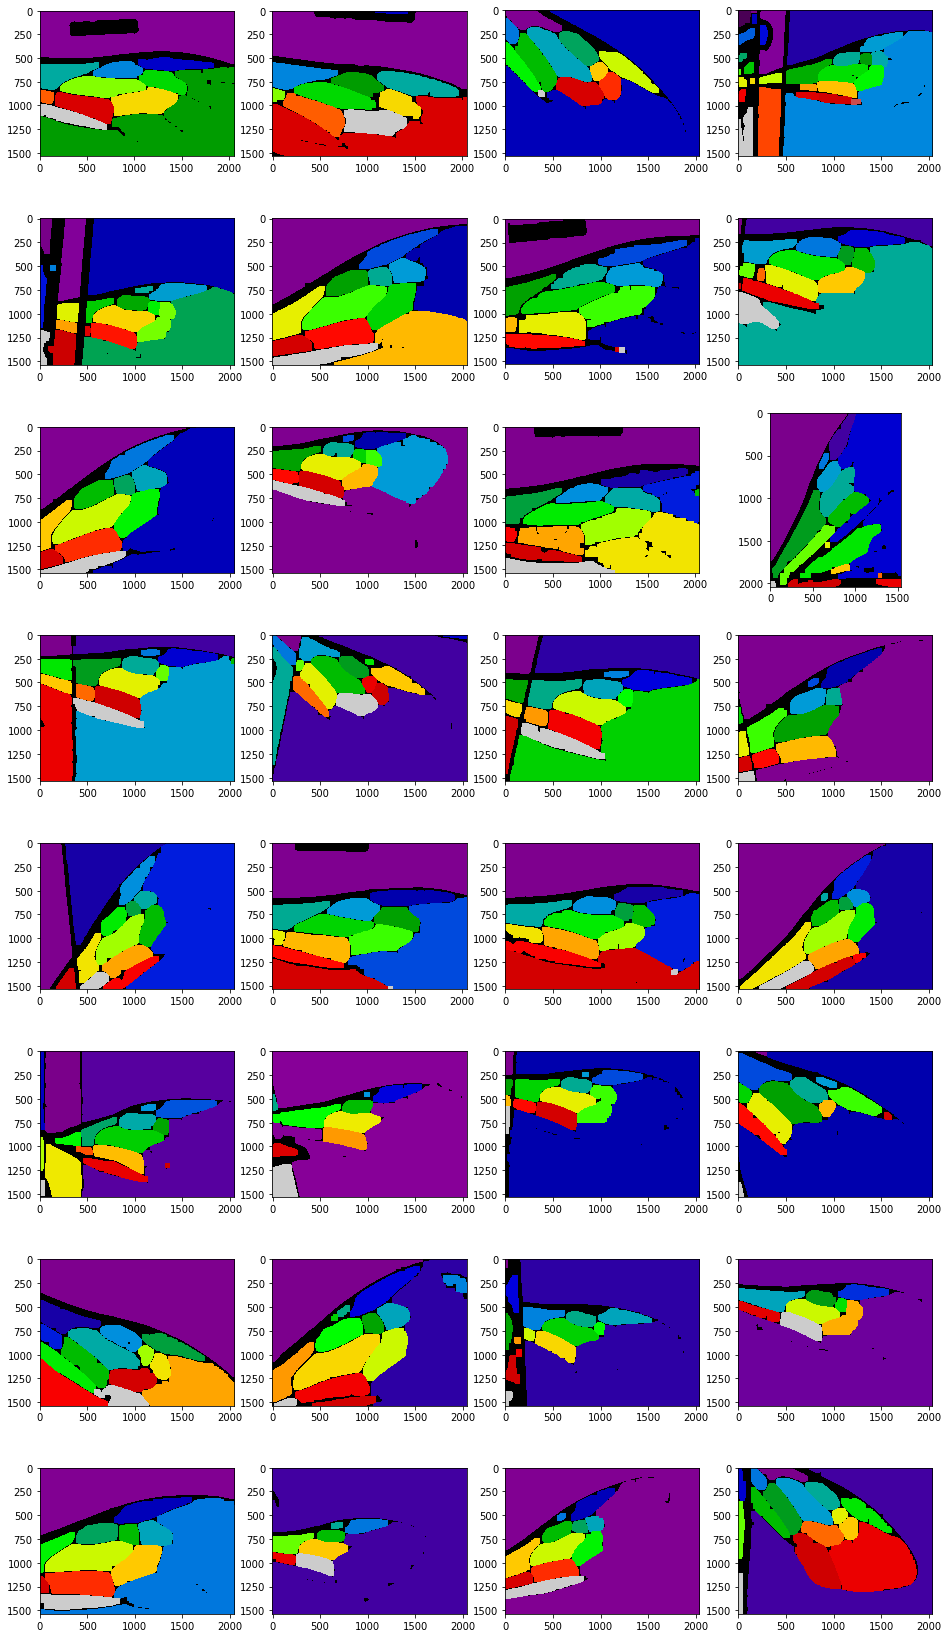

In [8]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process(img)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(ws, cmap='nipy_spectral')
plt.show()

# Intersections Detection

In [1]:
def intersect(img):
    #fig=plt.figure(figsize=(18, 18))

    height, width = img.shape
    step = 60
    intersects = np.full(img.shape, 0)
    for i in range(0, height-step, step//2):
        for j in range(0, width-step, step//2):
            
            colors = set()
            for k in range(i, i+step):
                for l in range(j, j+step):
                    pixel = img[k][l]
                    if pixel != -1 and pixel not in colors:
                        colors.add(pixel)
            if len(colors) >= 4:
                intersects[i+step//2][j+step//2] = 1
                
                
    # mean
    step = 100
    res = set() # set of tuple
    intersects2 = np.full(img.shape, 0)
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                intersects2[mean[0]][mean[1]] = 1
                res.add(mean)
            else:
                for point in pts:
                    intersects2[point[0]][point[1]] = 255
                    res.add(point)

    #fig.add_subplot(2, 1, 1)
    #plt.imshow(draw_points(img, res))         
    
    # mean
    step = 100
    res = set() # set of tuple
    for i in range(50, height-step, step):
        for j in range(50, width-step, step):
            
            # print grid
            for i2 in range(0, 5):
                for j2 in range(0, 5):
                    img[i + i2][j + j2] = 255
            
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects2[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                res.add(mean)
            else:
                for point in pts:
                    res.add(point)
    return res

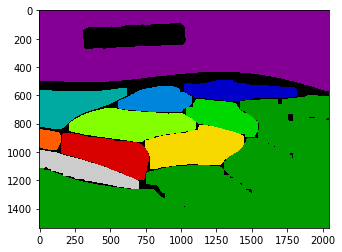

In [10]:
img = train_imgs[0].copy()
ws = process(img)
plt.imshow(ws, cmap='nipy_spectral')

In [11]:
points = intersect(ws)

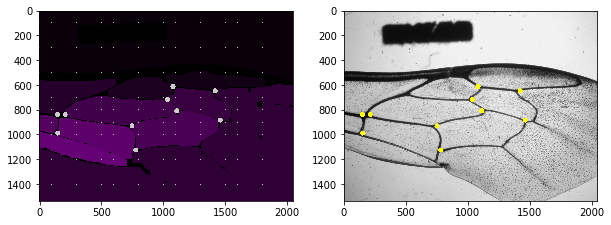

In [12]:
fig=plt.figure(figsize=(20, 20))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(ws, points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(img, points))

plt.show()

# Detection on train images

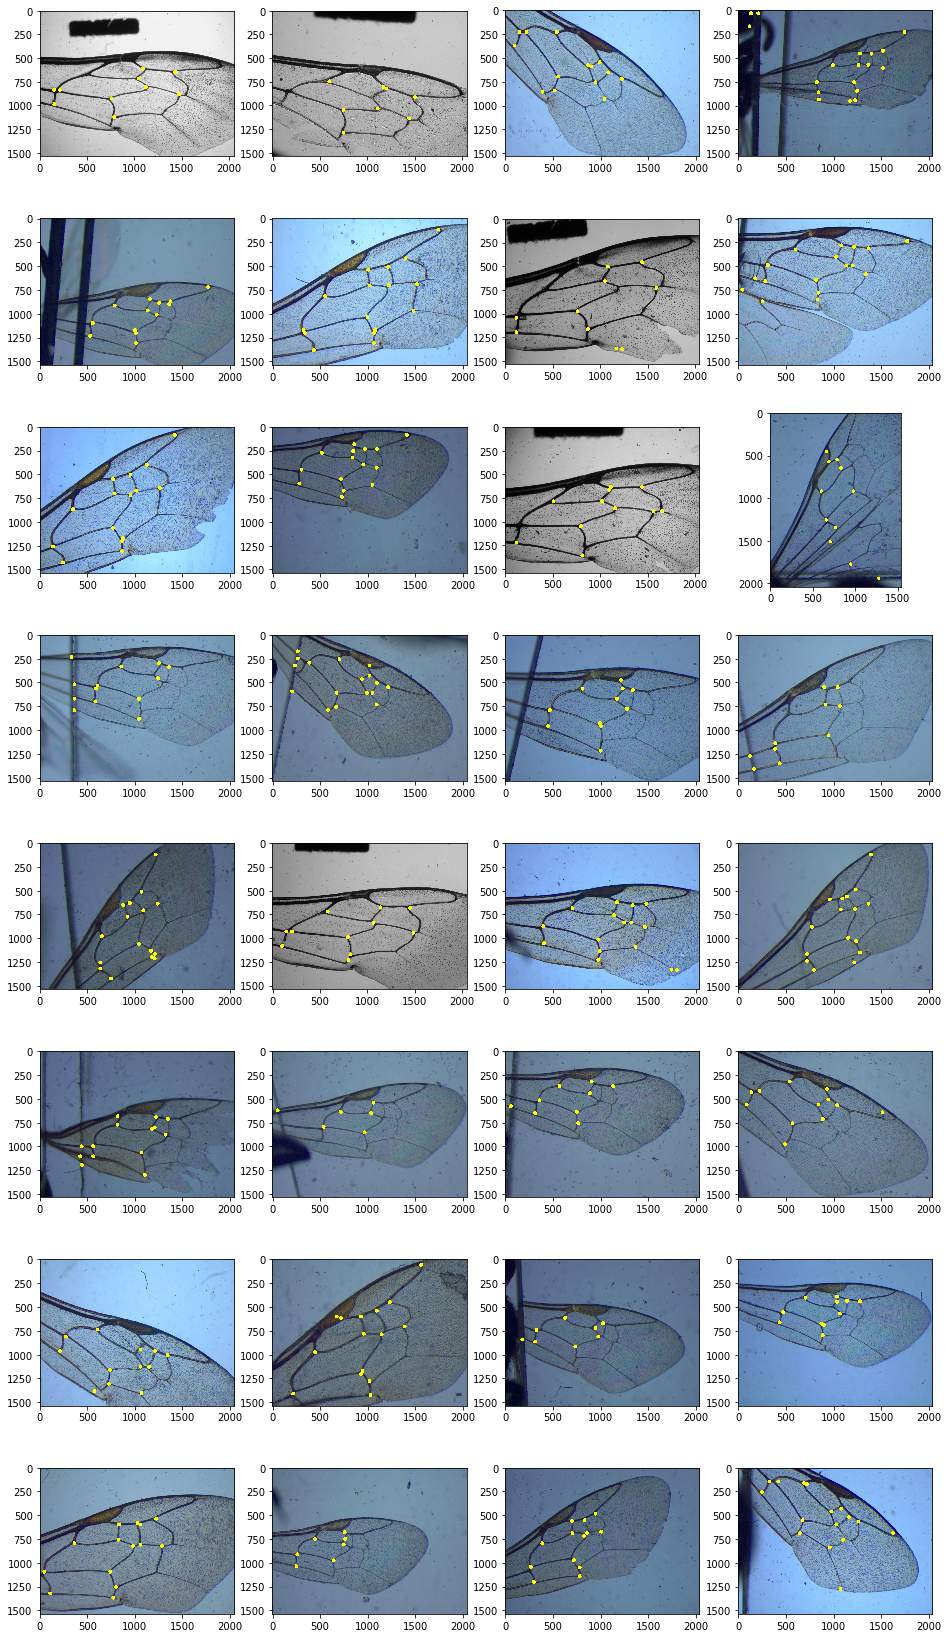

In [14]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process(img)
    points = intersect(ws)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points(img, points))
plt.show()


# Detection on test image

In [38]:
test_img = test_imgs[0]
test_points = test_labels[0]
ws = process(test_img)
points = intersect(ws)

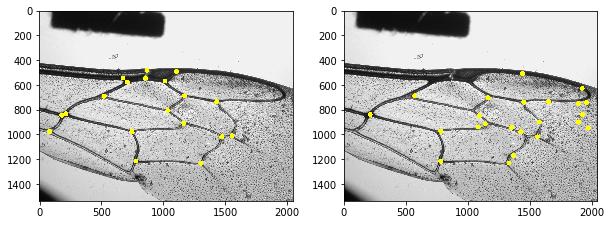

In [39]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(test_img, test_points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(test_img, points))

plt.show()

# Compute score

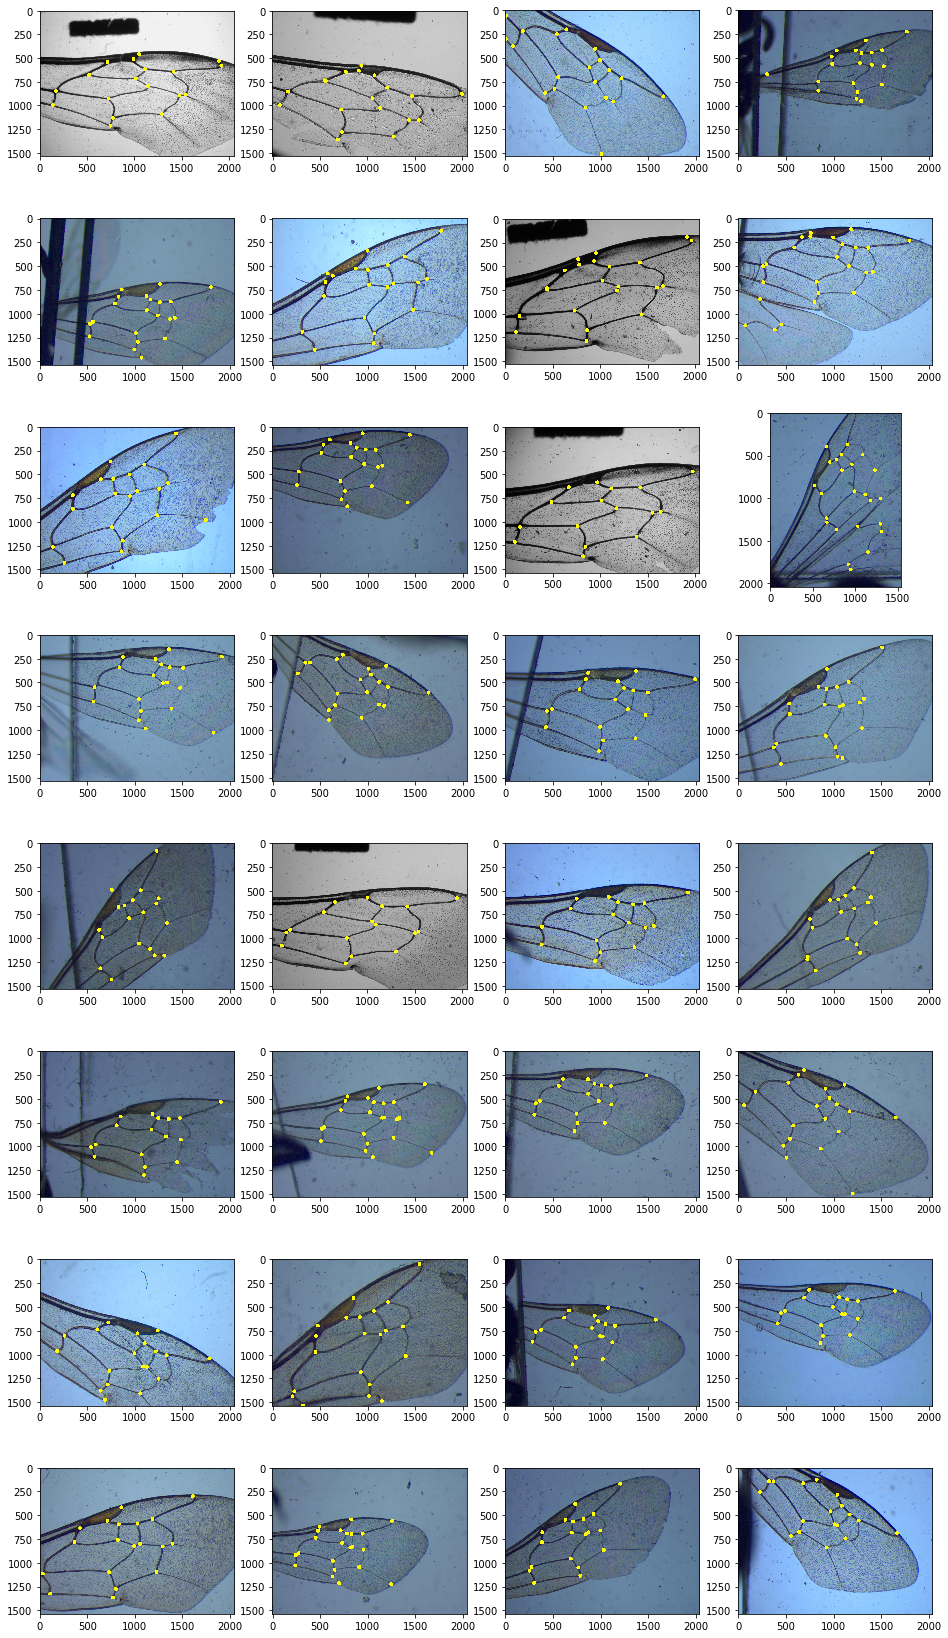

In [18]:
fig=plt.figure(figsize=(16, 30))
for i in range(0, len(train_imgs)):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points(train_imgs[i], train_labels[i]))

In [19]:
def compute_score(data_x, labels):
    preds = data_x.copy()
    good = set()
    for label in labels:
        for pred in preds:
            if label[0] > pred[0] - 30 and label[0] < pred[0] + 30 and label[1] > pred[1] - 30 and label[1] < pred[1] + 30:
                # pred is correct
                good.add(pred)
                preds.remove(pred)
                break
    precision = len(good) / len(data_x)
    recall = len(good) / len(labels)
    f1 = 2.0 * precision * recall / (precision + recall)
    return precision, recall, f1

In [26]:
def compute_score_total(imgs, labels):
    precision = 0.0
    recall = 0.0
    f1 = 0.0
    for i in range (0, len(imgs)):
        img = imgs[i].copy()
        ws = process(img)
        points = intersect(ws)
        p, r, f = compute_score(points, labels[i])
        precision += p
        recall += r
        f1 += f
        print("%2d: %.2f %.2f %.2f" % (i, p, r, f))
    print('\nprecision : ', precision / len(imgs))
    print('recall : ', recall / len(imgs))    
    print('F1 score : ', f1 / len(imgs))

In [27]:
# Train score
compute_score_total(train_imgs, train_labels)

 0: 0.80 0.44 0.57
 1: 0.62 0.26 0.37
 2: 0.79 0.55 0.65
 3: 0.67 0.60 0.63
 4: 0.77 0.48 0.59
 5: 0.88 0.67 0.76
 6: 0.70 0.32 0.44
 7: 0.76 0.52 0.62
 8: 0.93 0.70 0.80
 9: 0.80 0.57 0.67
10: 0.82 0.56 0.67
11: 0.64 0.29 0.40
12: 0.54 0.35 0.42
13: 0.65 0.55 0.59
14: 0.73 0.42 0.53
15: 0.80 0.38 0.52
16: 0.69 0.58 0.63
17: 0.82 0.53 0.64
18: 0.75 0.71 0.73
19: 0.81 0.72 0.76
20: 0.64 0.53 0.58
21: 0.83 0.22 0.34
22: 0.89 0.47 0.62
23: 0.75 0.45 0.56
24: 0.83 0.53 0.65
25: 0.73 0.52 0.61
26: 0.75 0.32 0.44
27: 0.82 0.53 0.64
28: 0.86 0.63 0.73
29: 0.86 0.27 0.41
30: 0.92 0.63 0.75
31: 0.62 0.56 0.59

precision :  0.7646081808306072
recall :  0.4955269949430608
F1 score :  0.5910390236840797


In [41]:
# Test score
compute_score_total(test_imgs, test_labels)

 0: 0.30 0.37 0.33
 1: 0.71 0.52 0.60
 2: 0.93 0.67 0.78
 3: 0.88 0.61 0.72
 4: 0.75 0.55 0.63

precision :  0.7137127024722932
recall :  0.5421954094722973
F1 score :  0.6121277552856501
